# Module 2.4: Volume and Volatility Indicators

## Overview
This notebook covers volume and volatility indicators that provide crucial insights into market dynamics. You'll learn to implement and analyze Volume Profile, Bollinger Bands, Average True Range (ATR), and VIX, along with multi-timeframe analysis techniques.

## Learning Objectives
- Understand the importance of volume in technical analysis
- Implement Volume Profile and Volume Weighted Average Price (VWAP)
- Create Bollinger Bands and understand volatility bands
- Calculate Average True Range (ATR) for volatility measurement
- Analyze VIX for market sentiment
- Perform multi-timeframe analysis
- Combine volume and volatility indicators for trading signals

## Contents
1. Introduction to Volume and Volatility
2. Volume Profile and VWAP
3. Bollinger Bands
4. Average True Range (ATR)
5. VIX Analysis
6. Multi-timeframe Analysis
7. Trading Strategies with Volume and Volatility
8. Backtesting and Performance Analysis

## 1. Setup and Data Import

First, let's import the necessary libraries and load sample data for our analysis.

In [5]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
import warnings
import requests
import os
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Libraries imported successfully!")

Libraries imported successfully!


In [6]:
symbol = 'SPY'
start_date = '2025-01-01'
end_date = datetime.now().strftime("%Y-%m-%d")
session = requests.Session()
proxy_host = "localhost"
proxy_port = 10809
proxy_url = f"http://{proxy_host}:{proxy_port}"
session.proxies.update(
    {
        "http": proxy_url,
        "https": proxy_url,
    }
)
os.environ['HTTP_PROXY'] = proxy_url
os.environ['HTTPS_PROXY'] = proxy_url
ticker = yf.Ticker(symbol)
ticker.session = session
# Download data
data = ticker.history(start=start_date, end=end_date, interval='1d')
data = data.round(2)

print(f"Downloaded {len(data)} days of data for {symbol}")
print(f"Date range: {data.index[0].date()} to {data.index[-1].date()}")
print("\nFirst 5 rows:")
data.head()

Downloaded 135 days of data for SPY
Date range: 2025-01-02 to 2025-07-18

First 5 rows:


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2025-01-02 00:00:00-05:00,585.89,587.62,577.05,581.17,50204000,0.0,0.0,0.0
2025-01-03 00:00:00-05:00,584.04,589.08,582.95,588.44,37888500,0.0,0.0,0.0
2025-01-06 00:00:00-05:00,592.73,596.14,590.08,591.82,47679400,0.0,0.0,0.0
2025-01-07 00:00:00-05:00,593.87,594.20,583.30,585.13,60393100,0.0,0.0,0.0
2025-01-08 00:00:00-05:00,585.20,587.07,581.73,585.99,47304700,0.0,0.0,0.0


## 2. Volume Profile and VWAP

Volume Profile shows the distribution of trading volume at different price levels, while VWAP (Volume Weighted Average Price) provides a benchmark for fair value.

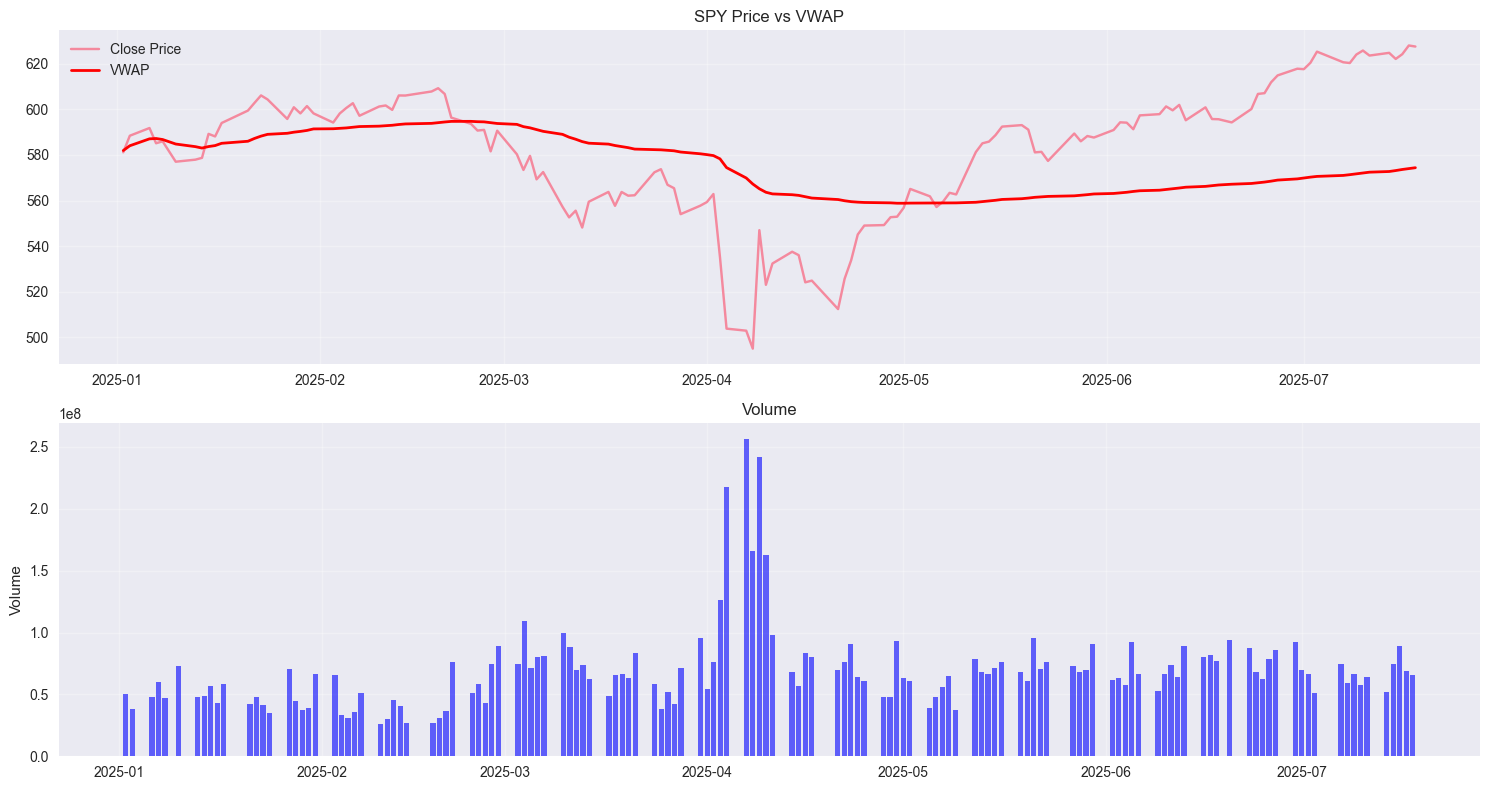

VWAP Analysis:
Average VWAP: $575.57
Current VWAP: $574.41
Current Price: $627.58


In [7]:
def calculate_vwap(data):
    """
    Calculate Volume Weighted Average Price (VWAP)
    
    Parameters:
    data: DataFrame with columns ['High', 'Low', 'Close', 'Volume']
    
    Returns:
    Series: VWAP values
    """
    # Calculate typical price
    typical_price = (data['High'] + data['Low'] + data['Close']) / 3
    
    # Calculate cumulative volume and cumulative typical price * volume
    cum_vol = data['Volume'].cumsum()
    cum_tp_vol = (typical_price * data['Volume']).cumsum()
    
    # Calculate VWAP
    vwap = cum_tp_vol / cum_vol
    
    return vwap

# Calculate VWAP
data['VWAP'] = calculate_vwap(data)

# Plot price vs VWAP
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(data.index, data['Close'], label='Close Price', alpha=0.8)
plt.plot(data.index, data['VWAP'], label='VWAP', color='red', linewidth=2)
plt.title(f'{symbol} Price vs VWAP')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.bar(data.index, data['Volume'], alpha=0.6, color='blue')
plt.title('Volume')
plt.ylabel('Volume')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("VWAP Analysis:")
print(f"Average VWAP: ${data['VWAP'].mean():.2f}")
print(f"Current VWAP: ${data['VWAP'].iloc[-1]:.2f}")
print(f"Current Price: ${data['Close'].iloc[-1]:.2f}")

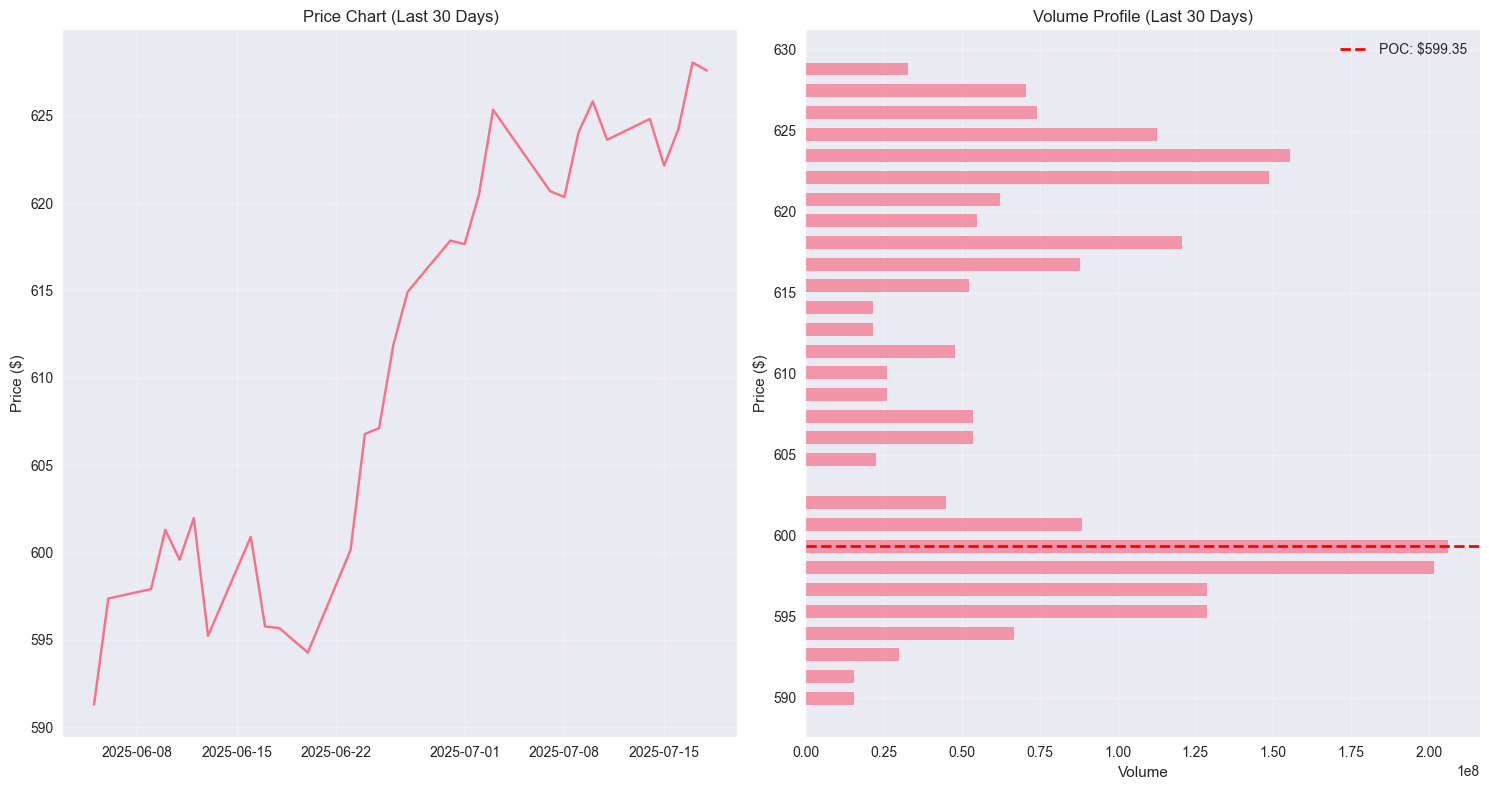

Point of Control (POC): $599.35
Total Volume in Profile: 2,171,238,500


In [8]:
def create_volume_profile(data, bins=50, period_days=30):
    """
    Create Volume Profile for a specific period
    
    Parameters:
    data: DataFrame with OHLCV data
    bins: Number of price bins
    period_days: Number of days to analyze
    
    Returns:
    DataFrame: Volume profile data
    """
    # Get recent data
    recent_data = data.tail(period_days).copy()
    
    # Define price range
    price_min = recent_data['Low'].min()
    price_max = recent_data['High'].max()
    
    # Create price bins
    price_bins = np.linspace(price_min, price_max, bins + 1)
    bin_centers = (price_bins[:-1] + price_bins[1:]) / 2
    
    # Initialize volume profile
    volume_profile = np.zeros(bins)
    
    # Distribute volume across price levels
    for _, row in recent_data.iterrows():
        high, low, volume = row['High'], row['Low'], row['Volume']
        
        # Find bins that overlap with the day's range
        overlapping_bins = np.where((bin_centers >= low) & (bin_centers <= high))[0]
        
        if len(overlapping_bins) > 0:
            # Distribute volume equally across overlapping bins
            volume_per_bin = volume / len(overlapping_bins)
            volume_profile[overlapping_bins] += volume_per_bin
    
    # Create result DataFrame
    profile_df = pd.DataFrame({
        'Price': bin_centers,
        'Volume': volume_profile
    })
    
    return profile_df

# Create volume profile for last 30 days
volume_profile = create_volume_profile(data, bins=30, period_days=30)

# Plot volume profile
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Price chart
recent_data = data.tail(30)
ax1.plot(recent_data.index, recent_data['Close'])
ax1.set_title('Price Chart (Last 30 Days)')
ax1.set_ylabel('Price ($)')
ax1.grid(True, alpha=0.3)

# Volume profile
ax2.barh(volume_profile['Price'], volume_profile['Volume'], alpha=0.7)
ax2.set_title('Volume Profile (Last 30 Days)')
ax2.set_xlabel('Volume')
ax2.set_ylabel('Price ($)')
ax2.grid(True, alpha=0.3)

# Find Point of Control (POC) - price level with highest volume
poc_price = volume_profile.loc[volume_profile['Volume'].idxmax(), 'Price']
ax2.axhline(y=poc_price, color='red', linestyle='--', linewidth=2, label=f'POC: ${poc_price:.2f}')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"Point of Control (POC): ${poc_price:.2f}")
print(f"Total Volume in Profile: {volume_profile['Volume'].sum():,.0f}")

## 3. Bollinger Bands

Bollinger Bands consist of a moving average and two standard deviation bands that expand and contract based on market volatility.

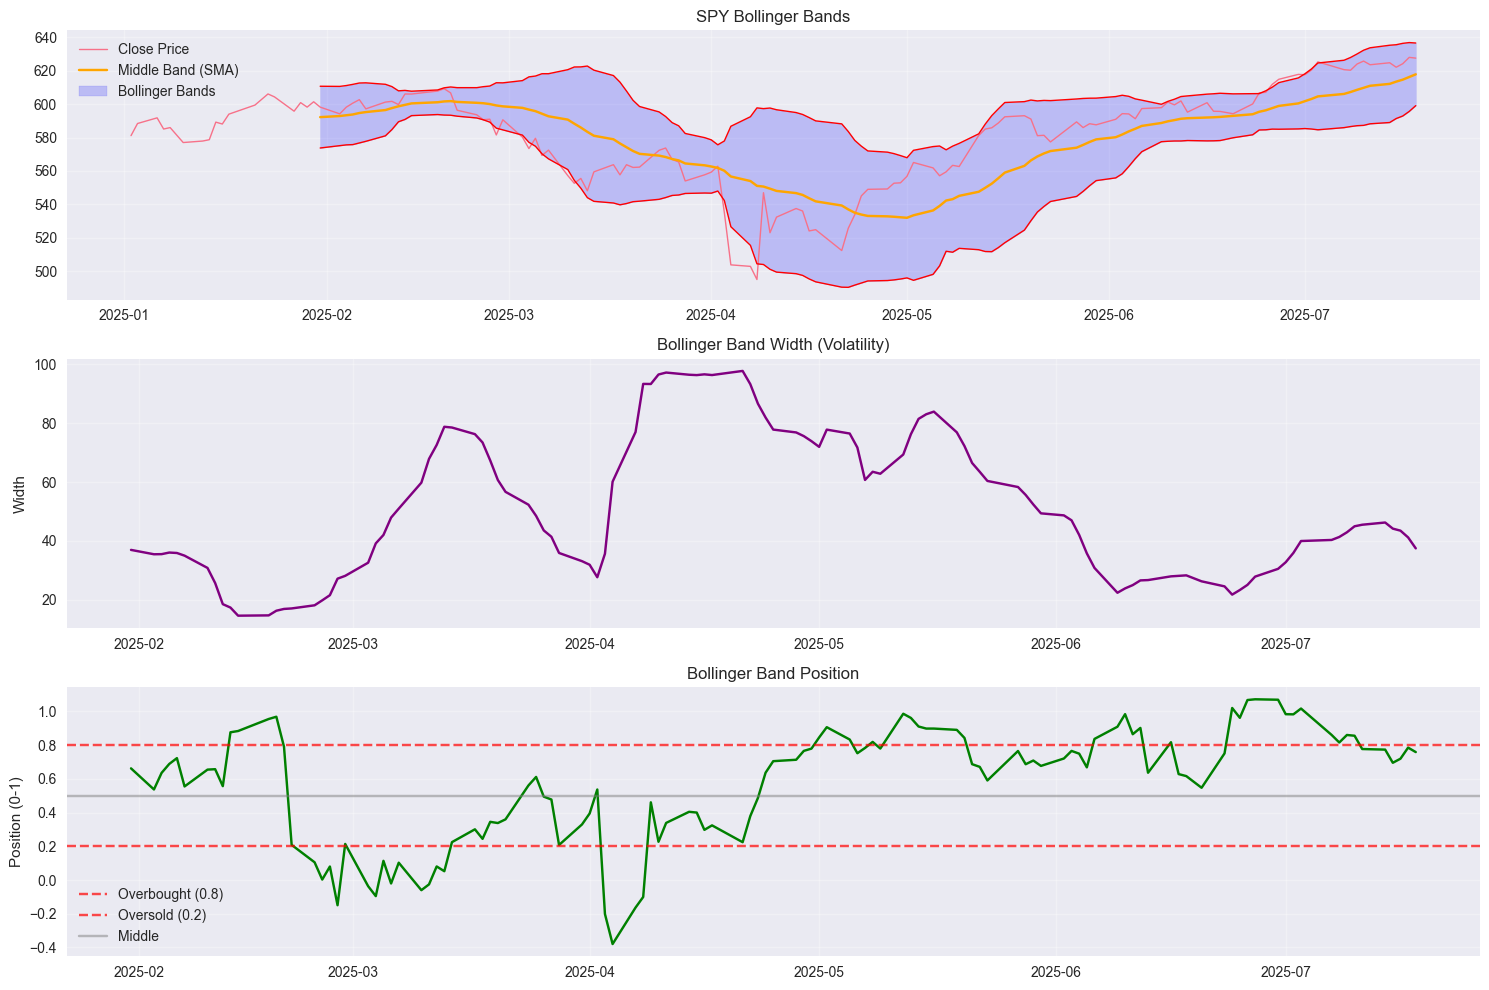

Bollinger Bands Analysis:
Current BB Position: 0.759
Current BB Width: $37.49
Average BB Width: $50.77
Volatility Status: Low
Signal: Neutral


In [9]:
def calculate_bollinger_bands(data, window=20, num_std=2):
    """
    Calculate Bollinger Bands
    
    Parameters:
    data: DataFrame with 'Close' column
    window: Period for moving average
    num_std: Number of standard deviations for bands
    
    Returns:
    DataFrame: DataFrame with Bollinger Bands
    """
    # Calculate moving average
    ma = data['Close'].rolling(window=window).mean()
    
    # Calculate standard deviation
    std = data['Close'].rolling(window=window).std()
    
    # Calculate upper and lower bands
    upper_band = ma + (std * num_std)
    lower_band = ma - (std * num_std)
    
    return pd.DataFrame({
        'Middle_Band': ma,
        'Upper_Band': upper_band,
        'Lower_Band': lower_band,
        'BB_Width': upper_band - lower_band,
        'BB_Position': (data['Close'] - lower_band) / (upper_band - lower_band)
    })

# Calculate Bollinger Bands
bb_data = calculate_bollinger_bands(data, window=20, num_std=2)
combined_data = pd.concat([data, bb_data], axis=1)

# Plot Bollinger Bands
plt.figure(figsize=(15, 10))

# Price and Bollinger Bands
plt.subplot(3, 1, 1)
plt.plot(combined_data.index, combined_data['Close'], label='Close Price', linewidth=1)
plt.plot(combined_data.index, combined_data['Middle_Band'], label='Middle Band (SMA)', color='orange')
plt.fill_between(combined_data.index, combined_data['Upper_Band'], combined_data['Lower_Band'], 
                 alpha=0.2, color='blue', label='Bollinger Bands')
plt.plot(combined_data.index, combined_data['Upper_Band'], color='red', linewidth=1)
plt.plot(combined_data.index, combined_data['Lower_Band'], color='red', linewidth=1)
plt.title(f'{symbol} Bollinger Bands')
plt.legend()
plt.grid(True, alpha=0.3)

# Bollinger Band Width
plt.subplot(3, 1, 2)
plt.plot(combined_data.index, combined_data['BB_Width'], color='purple')
plt.title('Bollinger Band Width (Volatility)')
plt.ylabel('Width')
plt.grid(True, alpha=0.3)

# Bollinger Band Position
plt.subplot(3, 1, 3)
plt.plot(combined_data.index, combined_data['BB_Position'], color='green')
plt.axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='Overbought (0.8)')
plt.axhline(y=0.2, color='red', linestyle='--', alpha=0.7, label='Oversold (0.2)')
plt.axhline(y=0.5, color='gray', linestyle='-', alpha=0.5, label='Middle')
plt.title('Bollinger Band Position')
plt.ylabel('Position (0-1)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analysis
current_position = combined_data['BB_Position'].iloc[-1]
current_width = combined_data['BB_Width'].iloc[-1]
avg_width = combined_data['BB_Width'].mean()

print("Bollinger Bands Analysis:")
print(f"Current BB Position: {current_position:.3f}")
print(f"Current BB Width: ${current_width:.2f}")
print(f"Average BB Width: ${avg_width:.2f}")
print(f"Volatility Status: {'High' if current_width > avg_width else 'Low'}")

if current_position > 0.8:
    print("Signal: Potentially Overbought")
elif current_position < 0.2:
    print("Signal: Potentially Oversold")
else:
    print("Signal: Neutral")

## 4. Average True Range (ATR)

Average True Range measures volatility by calculating the average of true ranges over a specified period.

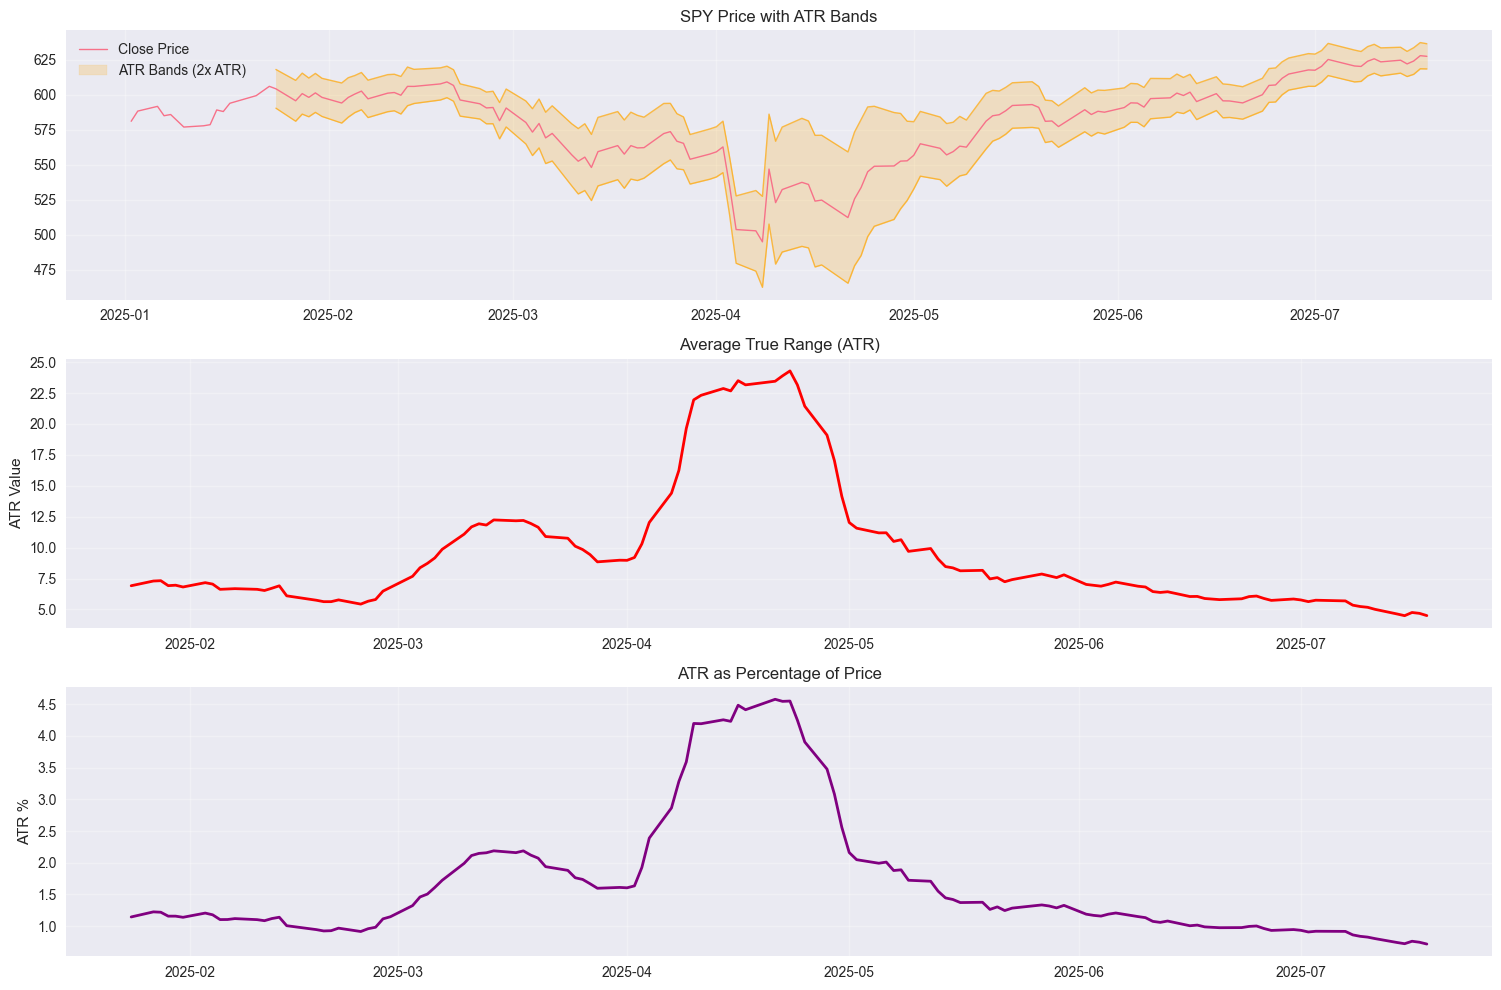

ATR Analysis:
Current ATR: $4.50
Current ATR as % of price: 0.72%
Average ATR as % of price: 1.69%
Volatility Status: Low
ATR-based Stop Loss (2x ATR): $618.58
ATR-based Take Profit (2x ATR): $636.58


In [10]:
def calculate_atr(data, window=14):
    """
    Calculate Average True Range (ATR)
    
    Parameters:
    data: DataFrame with OHLC data
    window: Period for ATR calculation
    
    Returns:
    Series: ATR values
    """
    # Calculate True Range components
    high_low = data['High'] - data['Low']
    high_close_prev = np.abs(data['High'] - data['Close'].shift(1))
    low_close_prev = np.abs(data['Low'] - data['Close'].shift(1))
    
    # True Range is the maximum of the three components
    true_range = np.maximum(high_low, np.maximum(high_close_prev, low_close_prev))
    
    # ATR is the moving average of True Range
    atr = true_range.rolling(window=window).mean()
    
    return atr, true_range

# Calculate ATR
data['ATR'], data['True_Range'] = calculate_atr(data, window=14)

# Calculate ATR-based support and resistance levels
data['ATR_Upper'] = data['Close'] + (data['ATR'] * 2)
data['ATR_Lower'] = data['Close'] - (data['ATR'] * 2)

# Plot ATR analysis
plt.figure(figsize=(15, 10))

# Price with ATR bands
plt.subplot(3, 1, 1)
plt.plot(data.index, data['Close'], label='Close Price', linewidth=1)
plt.fill_between(data.index, data['ATR_Upper'], data['ATR_Lower'], 
                 alpha=0.2, color='orange', label='ATR Bands (2x ATR)')
plt.plot(data.index, data['ATR_Upper'], color='orange', linewidth=1, alpha=0.7)
plt.plot(data.index, data['ATR_Lower'], color='orange', linewidth=1, alpha=0.7)
plt.title(f'{symbol} Price with ATR Bands')
plt.legend()
plt.grid(True, alpha=0.3)

# ATR values
plt.subplot(3, 1, 2)
plt.plot(data.index, data['ATR'], color='red', linewidth=2)
plt.title('Average True Range (ATR)')
plt.ylabel('ATR Value')
plt.grid(True, alpha=0.3)

# ATR as percentage of price
plt.subplot(3, 1, 3)
atr_percentage = (data['ATR'] / data['Close']) * 100
plt.plot(data.index, atr_percentage, color='purple', linewidth=2)
plt.title('ATR as Percentage of Price')
plt.ylabel('ATR %')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ATR Analysis
current_atr = data['ATR'].iloc[-1]
current_price = data['Close'].iloc[-1]
atr_percentage_current = (current_atr / current_price) * 100
avg_atr_percentage = ((data['ATR'] / data['Close']) * 100).mean()

print("ATR Analysis:")
print(f"Current ATR: ${current_atr:.2f}")
print(f"Current ATR as % of price: {atr_percentage_current:.2f}%")
print(f"Average ATR as % of price: {avg_atr_percentage:.2f}%")
print(f"Volatility Status: {'High' if atr_percentage_current > avg_atr_percentage else 'Low'}")
print(f"ATR-based Stop Loss (2x ATR): ${current_price - (2 * current_atr):.2f}")
print(f"ATR-based Take Profit (2x ATR): ${current_price + (2 * current_atr):.2f}")

## 5. VIX Analysis

The VIX (Volatility Index) measures market fear and volatility expectations. We'll analyze VIX data and its relationship with market movements.

## 6. Multi-timeframe Analysis

Analyzing indicators across different timeframes provides a more comprehensive view of market conditions.

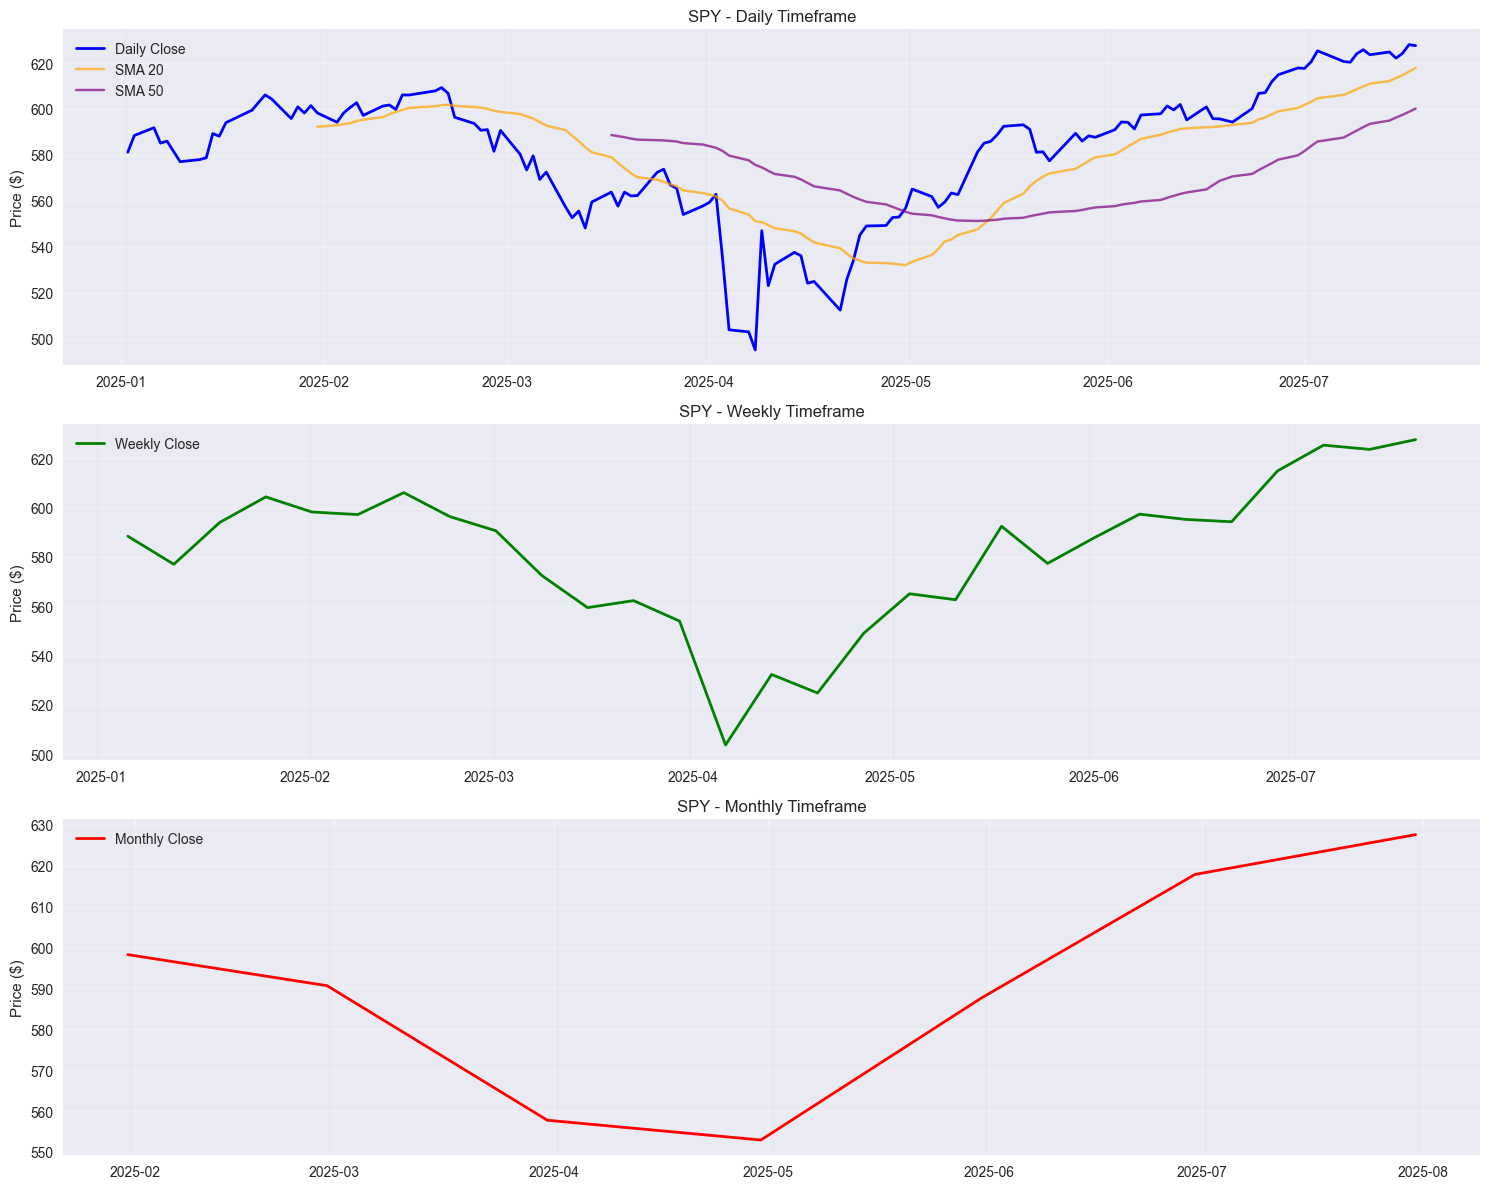

Multi-Timeframe Analysis Summary:

Daily Timeframe:
  BB Position: 0.759
  ATR %: 0.72%
  Price vs SMA20: +1.57%
  Price vs SMA50: +4.57%

Weekly Timeframe:
  BB Position: 0.877
  ATR %: 3.00%
  Price vs SMA20: +8.94%
  Price vs SMA50: +nan%

Monthly Timeframe:
  BB Position: nan
  ATR %: nan%
  Price vs SMA20: +nan%
  Price vs SMA50: +nan%


In [14]:
def resample_data(data, timeframe):
    """
    Resample data to different timeframes
    
    Parameters:
    data: DataFrame with OHLCV data
    timeframe: Target timeframe ('W' for weekly, 'M' for monthly)
    
    Returns:
    DataFrame: Resampled data
    """
    resampled = data.resample(timeframe).agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'
    }).dropna()
    
    return resampled

# Create multiple timeframes
daily_data = data.copy()
weekly_data = resample_data(data, 'W')
monthly_data = resample_data(data, 'M')

timeframes = {
    'Daily': daily_data,
    'Weekly': weekly_data,
    'Monthly': monthly_data
}

# Calculate indicators for each timeframe
def calculate_multi_timeframe_indicators(data_dict):
    """Calculate indicators for multiple timeframes"""
    results = {}
    
    for tf_name, tf_data in data_dict.items():
        # Bollinger Bands
        bb = calculate_bollinger_bands(tf_data, window=20, num_std=2)
        
        # ATR
        atr, _ = calculate_atr(tf_data, window=14)
        
        # Moving averages
        sma_20 = tf_data['Close'].rolling(20).mean()
        sma_50 = tf_data['Close'].rolling(50).mean()
        
        results[tf_name] = {
            'data': tf_data,
            'bb_position': bb['BB_Position'].iloc[-1] if len(bb) > 0 else None,
            'atr_pct': (atr.iloc[-1] / tf_data['Close'].iloc[-1] * 100) if len(atr) > 0 else None,
            'price_vs_sma20': ((tf_data['Close'].iloc[-1] / sma_20.iloc[-1]) - 1) * 100 if len(sma_20) > 0 else None,
            'price_vs_sma50': ((tf_data['Close'].iloc[-1] / sma_50.iloc[-1]) - 1) * 100 if len(sma_50) > 0 else None,
        }
    
    return results

# Calculate indicators
mtf_results = calculate_multi_timeframe_indicators(timeframes)

# Plot multi-timeframe analysis
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

colors = ['blue', 'green', 'red']
for i, (tf_name, tf_info) in enumerate(mtf_results.items()):
    ax = axes[i]
    tf_data = tf_info['data']
    
    # Plot price
    ax.plot(tf_data.index, tf_data['Close'], color=colors[i], linewidth=2, label=f'{tf_name} Close')
    
    # Add moving averages if enough data
    if len(tf_data) >= 50:
        sma_20 = tf_data['Close'].rolling(20).mean()
        sma_50 = tf_data['Close'].rolling(50).mean()
        ax.plot(tf_data.index, sma_20, color='orange', alpha=0.7, label='SMA 20')
        ax.plot(tf_data.index, sma_50, color='purple', alpha=0.7, label='SMA 50')
    
    ax.set_title(f'{symbol} - {tf_name} Timeframe')
    ax.set_ylabel('Price ($)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display multi-timeframe summary
print("Multi-Timeframe Analysis Summary:")
print("=" * 50)

for tf_name, tf_info in mtf_results.items():
    print(f"\n{tf_name} Timeframe:")
    print(f"  BB Position: {tf_info['bb_position']:.3f}" if tf_info['bb_position'] else "  BB Position: N/A")
    print(f"  ATR %: {tf_info['atr_pct']:.2f}%" if tf_info['atr_pct'] else "  ATR %: N/A")
    print(f"  Price vs SMA20: {tf_info['price_vs_sma20']:+.2f}%" if tf_info['price_vs_sma20'] else "  Price vs SMA20: N/A")
    print(f"  Price vs SMA50: {tf_info['price_vs_sma50']:+.2f}%" if tf_info['price_vs_sma50'] else "  Price vs SMA50: N/A")

## Summary and Key Takeaways

### Volume and Volatility Indicators Summary:

1. **Volume Profile & VWAP**:
   - Volume Profile shows price levels with highest trading activity
   - VWAP provides a fair value benchmark
   - Point of Control (POC) acts as support/resistance

2. **Bollinger Bands**:
   - Dynamic support and resistance levels
   - Band width indicates volatility
   - Price position within bands shows momentum

3. **Average True Range (ATR)**:
   - Measures volatility regardless of direction
   - Useful for position sizing and stop-loss placement
   - Higher ATR = higher volatility and risk

4. **VIX Analysis**:
   - Market fear gauge
   - Inverse correlation with market returns
   - Useful for market timing and sentiment analysis

5. **Multi-timeframe Analysis**:
   - Provides broader market context
   - Helps confirm signals across timeframes
   - Reduces false signals

### Trading Strategy Insights:
- Combining multiple indicators improves signal quality
- Volume confirmation is crucial for valid breakouts
- Volatility filtering helps identify better entry points
- Risk management using ATR is essential

### Next Steps:
- Experiment with different parameter values
- Add more sophisticated entry/exit rules
- Implement dynamic position sizing based on volatility
- Consider market regime detection
- Explore machine learning enhancement of signals